In [1]:
import numpy as np
import glob
from scipy import integrate, interpolate
import matplotlib
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['lines.dash_capstyle'] = "round"
matplotlib.rcParams['lines.solid_capstyle'] = "round"
matplotlib.rcParams['legend.handletextpad'] = 0.4

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}  \usepackage[T1]{fontenc}')

matplotlib.rcParams['axes.linewidth'] = 0.6
matplotlib.rcParams['ytick.major.width'] = 0.6
matplotlib.rcParams['xtick.major.width'] = 0.6
matplotlib.rcParams['ytick.minor.width'] = 0.45
matplotlib.rcParams['xtick.minor.width'] = 0.45
matplotlib.rcParams['ytick.major.size'] = 2.75
matplotlib.rcParams['xtick.major.size'] = 2.75
matplotlib.rcParams['ytick.minor.size'] = 1.75
matplotlib.rcParams['xtick.minor.size'] = 1.75
matplotlib.rcParams['legend.handlelength'] = 1.5

import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.colors import ListedColormap
import palettable
from scipy.integrate import ode
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy import optimize
import cmasher as cmr
import matplotlib.font_manager
from numpy import random
from scipy.stats import lognorm
from scipy.stats import norm

from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from ipynb.fs.full.utils import Matrix3D
import time

###########################
gamma   = 5/3.
kb      = 1.3806488e-16
mp      = 1.67373522381e-24
km      = 1e5
s       = 1
yr      = 3.1536e7
Myr     = 3.1536e13
Gyr     = 3.1536e16
pc      = 3.086e18
kpc     = 1.0e3 * pc
Mpc     = 1.0e6 * pc
H0      = 67.74*km/s/Mpc
Om      = 0.3075
OL      = 1 - Om
G       = 6.673e-8
Msun    = 2.e33
fb      = 0.158
keV     = 1.60218e-9
###########################


###########################
mu          = 0.62
metallicity = 10**-0.5
muH         = 1/0.75
###########################



Z0 = 1/3.
P0 = 1e3
T0 = 1e6
n0 = P0/T0
redshift=0
chi0 = 100.
Mach0 = 0.0
Turbulent_Scale0 = 1*kpc
f_turb0 = 0.1
f_mix = 0.1
v_hot0 = 0.
f_cool = 0.3
v = 1e2*km/s
f_ad = 0.1

P = 1e5*kb
rho = 1e-2*mu*mp
v = 1000*km/s


In [2]:
f_turb0 = 0.1
Mdot_chi_power = 0.5
def dot_cloud(M_cloud,v_cloud, dm_cloud, dv_cloud):
    # cloud_radius(M_cloud,v_cloud):
    T_cloud   = 1e4
    rho_cloud   = P * (mu*mp) / (kb*T_cloud) # cloud in pressure equilibrium
    chi         = rho_cloud / rho
    r_cloud     = (M_cloud / (rho_cloud))**(1/3.) 
    # layer_turbulent_velocity(M_cloud,v_cloud):
    v_turb      = f_turb0*(v-v_cloud)
    # layer_cooling_time(M_cloud,v_cloud):
#     t_cool_layer = 0.3*Myr ## just use this for now
    # cloud_ksi(M_cloud,v_cloud):
    T_wind  = P/kb * (mu*mp/rho)
    T_mix   = np.sqrt(T_wind*T_cloud)
    ksi     = r_cloud / (v_turb * t_cool_layer)
    # Mdot_cloud_grow(M_cloud,v_cloud):
    Mdot_grow   =  3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) * np.where( ksi < 1, ksi**0.5, ksi**0.25 )
    Mdot_loss   = -3 * M_cloud * v_turb / (r_cloud * chi**Mdot_chi_power) 
    force_from_transfer = (v-v_cloud)*Mdot_grow
    return (force_from_transfer/M_cloud)/dv_cloud/v_cloud, (Mdot_grow + Mdot_loss)/dm_cloud/v_cloud

In [3]:
def gen_bins(bmin, bmax, logScale, nbs_bins, unit):
    bin_size = (bmax-bmin)/nbs_bins
    bins = np.arange(bmin,bmax,bin_size)
    if logScale==True: 
        bins = 10**bins * unit
    else:
        bins = bins * unit
    return bins

def gen_uniform_dist(nbsample, xmin, xmax, unit):
    sample = random.uniform(xmin,xmax, nbsample)
    return sample * unit

def gen_lognormal_dist(nbsample, logmean, logstd, unit):
    sample=random.normal(logmean, logstd, nbsample)
    return 10 ** sample * unit

def gen_normal_dist(nbsample, mean, std, unit):
    sample=random.normal(mean, std, nbsample)
    return sample * unit

def gen_powerlaw(nbsample, xmin, xmax, power, unit):
    r = np.random.random(size=nbsample)
    ag, bg = xmin**power, xmax**power
    return (ag + (bg - ag)*r) ** (1./power) * unit

def gen_cloud(v_samples, m_samples, r_samples):
    sample=[]
    nb_vsam = len(v_samples)
    nb_msam = len(m_samples)
    nb_rsam = len(r_samples)
    if nb_vsam != nb_msam:
        if nb_vsam != nb_rsam:
            print("number of samples of velocity and Mass does not match")
    for i in range(nb_vsam):
        sample.append((i, v_samples[i], m_samples[i], r_samples[i]))
    return sample

def binnings(clouds, v_bins, M_bins):
    nbs_vbin= len(v_bins)
    nbs_Mbin= len(M_bins)
    f=np.reshape(np.zeros(nbs_vbin * nbs_Mbin),(nbs_vbin,nbs_Mbin))
    v_min = v_bins[0]
    v_max = v_bins[nbs_vbin-1]
    M_min = M_bins[0]
    M_max = M_bins[nbs_Mbin-1]
    for item in clouds:
        if (item[1]>=v_min) and (item[1]<=v_max) and (item[2]>=M_min) and (item[2]<=M_max):
            v_idx = np.max(np.where(v_bins <= item[1]))
            M_idx = np.max(np.where(M_bins <= item[2]))
            f[v_idx][M_idx]+=1
    return f

def binning2D(data, bins):
    (data1, data2) = (data[0], data[1])
    (bin1, bin2) = (bins[0], bins[1])
    nbs_bin1= len(bin1)
    nbs_bin2= len(bin2)
    f=np.reshape(np.zeros(nbs_bin1 * nbs_bin2),(nbs_bin1,nbs_bin2))
    d1_min = bin1[0]
    d1_max = bin1[nbs_bin1-1]
    d2_min = bin2[0]
    d2_max = bin2[nbs_bin2-1]
    for idx in range(len(data1)):
        if (data1[idx]>=d1_min) and (data1[idx]<=d1_max) and (data2[idx]>=d2_min) and (data2[idx]<=d2_max):
            d1_idx = np.max(np.where(bin1 <= data1[idx]))
            d2_idx = np.max(np.where(bin2 <= data2[idx]))
            f[d1_idx][d2_idx]+=1
    return f

def binning1D(data, bins):
    nbs_bins= len(bins)
    f=np.zeros(nbs_bins)
    d_min = bins[0]
    d_max = bins[nbs_bins-1]
    for idx in range(len(data)):
        if (data[idx]>=d_min) and (data[idx]<=d_max):
            d_idx = np.max(np.where(bins <= data[idx]))
            f[d_idx]+=1
    return f



def plot_density2D(f, data1, data2, labels, downscale):
    (bin1, unit1, log1) = data1
    (bin2, unit2, log2) = data2
    plt.figure(figsize=(6,6))
    plt.pcolormesh(bin1/unit1,bin2/unit2, np.abs(f)/downscale,cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap, norm=colors.SymLogNorm(vmin=1e-5,vmax=1e-3,linthresh=1e-6))
    if log1 == True:    
        plt.xscale('log')
    if log2 == True:
        plt.yscale('log')
    plt.xlabel(labels[1])
    plt.ylabel(labels[2])
    plt.title(labels[0])
    
    
def plot_density1D(f_init, f_final, log_y, data, labels, downscale):
    (bins, unit, log_x) = data
    plt.figure(figsize=(6,6))
    if (log_x == True):    
        bins_ = np.log10(bins / unit)
    else:
        bins_ = bins / unit
    if (log_y == True):
        fi = np.log10(f_init/np.sum(f_init))
        ff = np.log10(f_final/np.sum(f_final))
    else:
        fi = f_init/np.sum(f_init)
        ff = f_final/np.sum(f_final)       
    plt.plot(bins_, fi, label = 'Initial')
    plt.plot(bins_, ff, label = 'Final')
    plt.xlabel(labels[1])
    plt.ylabel(labels[2])
    plt.title(labels[0])
    plt.legend()

# not exactly lognormal but can generate approximate lognormal
# with its log10(x) having specificed mean and sigma in log space
def pseudo_lognormal(bmin, bmax, nbs_bins, mu, sigma, unit):
    bin_size = (bmax-bmin)/(nbs_bins+1)
    logbins = np.arange(bmin,bmax,bin_size)
    bins = 10**logbins * unit
    mu = mu + np.log10(unit)
    delta = bins[1:]-bins[:-1]
    z=(np.log10(bins)-mu)/sigma
    f = 1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-0.5*z**2)
    return f[1:], bins[1:], delta


def normal(bmin, bmax, nbs_bins, mu, sigma, unit):
    bin_size = (bmax-bmin)/(nbs_bins+1)
    bins = np.arange(bmin,bmax,bin_size) *unit
    delta = bins[1:]-bins[:-1]
    z = (bins/unit - mu)/(sigma)
    f=1/(sigma * unit * np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2) 
    return f[1:], bins[1:], delta

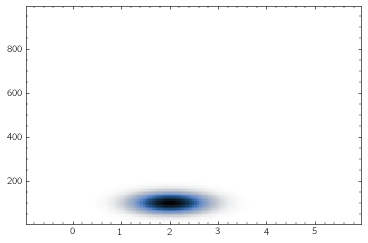

In [4]:
ncells_v=150
ncells_M=150
ncells_r=150
v_max = 1000
v_min = 0
M_max = 6
M_min = -1


(mf,mbin,dm)=pseudo_lognormal(M_min, M_max, ncells_M, 2, 0.5, Msun)
(vf,vbin,dv)=normal(v_min, v_max, ncells_v, 100,30,km)
phase = np.outer(vf,mf)
plt.pcolormesh(np.log10(mbin/Msun),vbin/km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


0
10


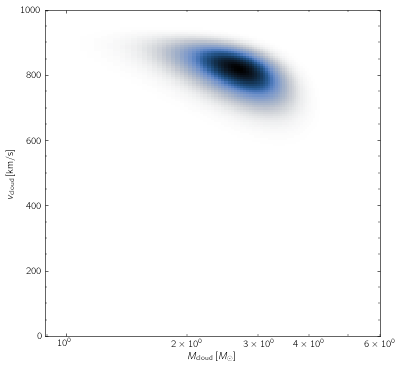

In [8]:
dr = 100 * pc
steps= 20

M0 = 1e2 * Msun
v0 = 100 * km
r_cloud     = (M0 / (rho*100))**(1/3.)
v_turb = f_turb0*(v-v0)
t_cool_layer = r_cloud / v_turb / 10**2
#t_cool_layer = 0.2  * Myr

indices = [(i,j) for j in range(ncells_v) for i in range(ncells_M)]
f0=[mf[item[0]]*vf[item[1]] for item in indices]

plt.figure(figsize=(6,6))

fn=f0
for i_time in range(steps):
    (_vdot, _mdot) = list(zip(*[dot_cloud(mbin[item[0]],vbin[item[1]], dm[item[0]], dv[item[1]]) for item in indices]))
    Mdot = np.array(_mdot) * dr
    vdot = np.array(_vdot) * dr
    diagonal = 1+Mdot+vdot
    M_neg_band = -Mdot[1:]
    v_neg_band = -vdot[ncells_M:]
    A = diags([diagonal, M_neg_band, v_neg_band],[0,-1,-ncells_M])
    fn = spsolve(A,fn)

    
    if i_time % 10 == 0:
#    if True:
        plt.pcolormesh(np.log10(mbin/Msun),vbin/km,np.reshape(fn,(ncells_M,ncells_v)), cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
        plt.xscale('log')
        plt.xlabel(r'$M_{\rm cloud}\, [M_\odot]$')
        plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
        plt.xlim((M_min,M_max))
        plt.ylim((v_min,v_max))
        print(i_time)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


199


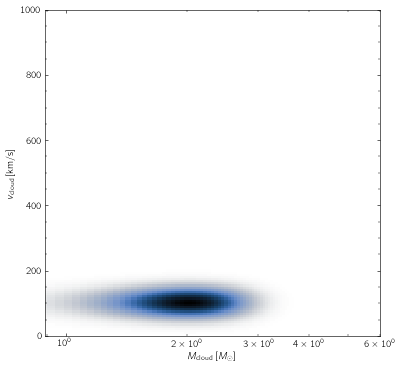

In [6]:
plt.figure(figsize=(6,6))
plt.pcolormesh(np.log10(mbin/Msun),vbin/km,phase, cmap=palettable.scientific.sequential.Oslo_20_r.mpl_colormap)
plt.xscale('log')
plt.xlabel(r'$M_{\rm cloud}\, [M_\odot]$')
plt.ylabel(r'$v_{\rm cloud}\, [{\rm km/s}]$')
plt.xlim((M_min,M_max))
plt.ylim((v_min,v_max))
print(i_time)
